<div style='border-style:solid;border-radius:10px;border-color:#000000;background-color:#6080B0;padding:30px;'>
    <div style='font-family:consolas;font-size:30px;color:#FFFFFF;text-align:center;line-height:150%'>Distinguishing Oscillating Patterns in Spatiotemporal Data</div><br>
    <div style='font-family:consolas;font-size:20px;color:#FFFFFF;text-align:center;'>
        <a class='top-links' (click)="openBlogSelector()">Posts</a>&nbsp;
        <a class='top-links' routerLink="/">Home</a>&nbsp;
        <a class='top-links' (click)="assets/lfca.component.ipynb">Notebook</a>
    </div>
</div>

<div style='border-style:solid;border-radius:10px;border-color:#000000;background-color:#DDDDDD;padding:30px;'>
    <div style='font-family:consolas;font-size:20px;text-align:center'>Summary</div><br>
    <div>
    </div>
</div>

<br>
<h2 style='text-align:center'>Introduction</h2>
<br>
In their paper <a href='https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2017GL076327'>"Disentangling Global Warming, Multidecadal Variability, and El Niño in Pacific Temperatures"</a>, Robert C. Wills et al. modify a dimension reduction technique to work with time series data, and use it to distinguish low-frequency coherent patterns in climate data. As per the title, they're able to tease apart a global warming trend, and several low frequency modes of internal variability, some of which were previously thought to be coupled. 

In this article, I'll demonstrate the method.

### Principle Component Analysis

Principle component analysis (PCA) is a method of dimensionality reduction, where the feature space of a data set X is rotated into an ordered set of basis vectors where each accounts for a maximum amount of data variance, unaccounted for by previous basis vectors.. That's a lot of words for a simple thing - oh, here's a good word:

> **front-load** <span style='color:gray'>verb \ ˈfrənt-ˌlōd  \ </span><br> to load or fill from the front.

So then, PCA provides an ordered basis which front-loads the variance, allowing you to discard later basis vectors with minimal loss of information. From hereon I'll call this the variance-front-loaded basis as opposed to the observation basis.

This is naturally achieved by rotating the data to the eigenbasis of the covariance matrix C=X<sup>T</sup>X, since this takes the form of a dilation operator with scaling axes conveniently arranged as described above.

Note: There seems to be a different choice of vocabulary for PCA concepts between the paper and most other literature. I'll be using the terminology from the paper:

eigenvectors of the covariance matrix (variance-front-loaded basis vectors)
- Literature: PCs
- Paper: EOFs, LFPs

projection of an eigenvector onto the data
- Literature: Component Scores <sup>[<a href='https://en.wikipedia.org/wiki/Principal_component_analysis'>source</a>]</sup>
- Paper: PCs, LFCs

### Low Frequency Component Analysis

We expect coherent physical processes to have characteristic frequencies - or more accurately, a bandwidth associated with the climate feedback loop. The aim of LFCA is to leverage the frequency information in spatiotemporal climate data to recast the maximally covarying patterns from PCA into a basis that also distinguishes characteristic frequencies.

Here's the recipe we'll follow:
1. Get EOFs and variances
    - Find the variance-front-loaded basis vectors and variances of the original data and keep N of them
2. Get filtered PCs
    - Filter the data and project it onto the EOFs to get the filtered principle components
3. Build LFPs and LFCs
    - Build LFPs from combinations of EOFs according to the variance-front-loaded basis of filtered principle components
    - Build LFCs by projecting the unfiltered data onto the variance-front-loaded basis of filtered principle components

<br>
<h2 style='text-align:center'>Creating Data</h2>
<br>
With that - let's code some of this. First - let's build a dataset with some gaussians oscillating at different frequencies,  amplitudes, phases, and sizes.

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from scipy.fftpack import fft
import numpy as np
import ipywidgets as widgets
from matplotlib import image
from sklearn.decomposition import PCA
from scipy import signal

# Declare some constants to make things easier to follow
MONTHS_PER_YEAR = 12
PI = np.pi

# We've got a data domain and a physical domain. Let's define some helpers.
# Some type definitions. For fun, let's keep things accurate
class physical_vector: 
    # read: time coordinate, spatial coordinate 1, spatial coordinate 2
    def __init__(self, t, u, v): self.t, self.u, self.v = t, u, v
class data_map: 
    # read: image lower bound, image upper bound, array element count, inter-element image step size
    def __init__(self, lwr, upr, cnt): self.lwr, self.upr, self.cnt, self.stp = lwr, upr, cnt, (upr - lwr) / cnt
    def to_physical_coordinates(self, i): return i * self.stp + self.lwr

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


To make this a little cleaner, we define a class for our animation data, with methods to add the gaussians.

In [2]:
class animation_class:
    
    def __init__(self, tdim, udim, vdim):
        # Initialize the data array and store the dimension information locally
        self.data = np.zeros(shape=(tdim.cnt, udim.cnt, vdim.cnt))
        self.tdim, self.udim, self.vdim = tdim, udim, vdim 

    
    def add_oscillating_guassian(self, period, offset, amplitude, sigma):
        for it in range(self.tdim.cnt):
            t = tdim.to_physical_coordinates(it)
            
            # Get the phase and amplitude for this time slice, and then paint it to the animation
            frequency = 2 * PI / period
            phase = (t - offset.t) * frequency
            slice_amplitude = amplitude * (1 + np.sin(phase))
            self.add_gaussian_slice(it, offset, slice_amplitude, sigma)
    
    
    def add_gaussian_slice(self, it, offset, amplitude, sigma):
        for iu in range(self.udim.cnt):
            u = udim.to_physical_coordinates(iu)
            for iv in range(self.vdim.cnt):
                v = vdim.to_physical_coordinates(iv)
    
                r = np.sqrt((u - offset.u)**2 + (v - offset.v)**2)
                self.data[it, iu, iv] += self.gaussian(r, amplitude, sigma)
        
        
    def gaussian(self, r, amplitude, sigma):
        return amplitude * np.exp (-r**2 / (2 * sigma**2))

Now we can create our data using some arbitrarily chosen values. The phase drift is plotted to make sure it's reasonable.

The paper uses NOAA's <a href='https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v3b'>ERSST v3b</a> data from 1900 to 2016 (1392 monthly samples), and 5&deg; spatial resolution (36 x 72 = 2592 grid points - assuming constant angular grid spacing).

The Nyquist frequency for this signal will be 0.5 samples per month. ie, we can detect signals with period as little as 2 months.

In [3]:
# Declare the extent and resolution of the simulation, and declare the array
tdim = data_map(lwr=0, upr=116*MONTHS_PER_YEAR, cnt=116*MONTHS_PER_YEAR)
udim = data_map(lwr=0, upr=50, cnt=50)
vdim = data_map(lwr=0, upr=50, cnt=50)

animation = animation_class(tdim, udim, vdim)
gaussian_periods = [2000, 7, 16, 48, 120]

# Choose some arbitrary values for the gaussian oscillation patterns, and compile the animation
w = widgets.IntProgress(max=5, description='executing:'); display(w)
animation.add_oscillating_guassian(gaussian_periods[0], physical_vector(50, 20, 15), amplitude=1,  sigma=15); w.value += 1
animation.add_oscillating_guassian(gaussian_periods[1], physical_vector(0, 38, 12),  amplitude=10, sigma=3); w.value += 1
animation.add_oscillating_guassian(gaussian_periods[2], physical_vector(10, 10, 34), amplitude=10, sigma=5); w.value += 1
animation.add_oscillating_guassian(gaussian_periods[3], physical_vector(34, 10, 8),  amplitude=10, sigma=5); w.value += 1
animation.add_oscillating_guassian(gaussian_periods[4], physical_vector(2, 29, 32),  amplitude=1,  sigma=10); w.value += 1

IntProgress(value=0, description='executing:', max=5)

Let's take a look at the data. (this is interactive in the notebook)

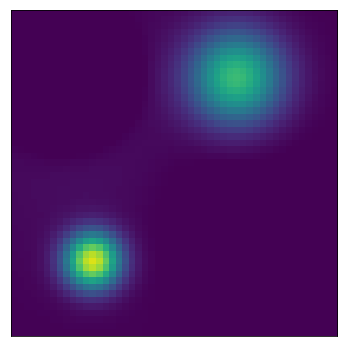

In [40]:
animation_max = np.max(animation.data)

def system_plot(it):     
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1,1,1, xticks=[], yticks=[])
    ax.imshow(animation.data[it, :, :], vmin=0, vmax=animation_max)
    plt.show()

# interactive_plot = widgets.interactive(system_plot, it = widgets.IntSlider(min=0, max=tdim.cnt-1, step=1, value=0))
# interactive_plot
system_plot(352)

And let's look at the space averaged power spectrum

In [6]:
unfiltered_tx_data = animation.data.reshape(tdim.cnt, -1)
unfiltered_tx_data -= np.mean(unfiltered_tx_data, axis=0, keepdims=True)

unfiltered_power_series = np.sum(unfiltered_tx_data.data, axis=1)
unfiltered_power_spectrum = 2.0 / tdim.cnt * abs(np.fft.fft(unfiltered_power_series))[:tdim.cnt//2]

frequencies = np.fft.fftfreq(tdim.cnt, d=tdim.stp)[:tdim.cnt//2] # Get the frequency labels, and clip off the second half - 
periods = 1 / frequencies[1:] / 12

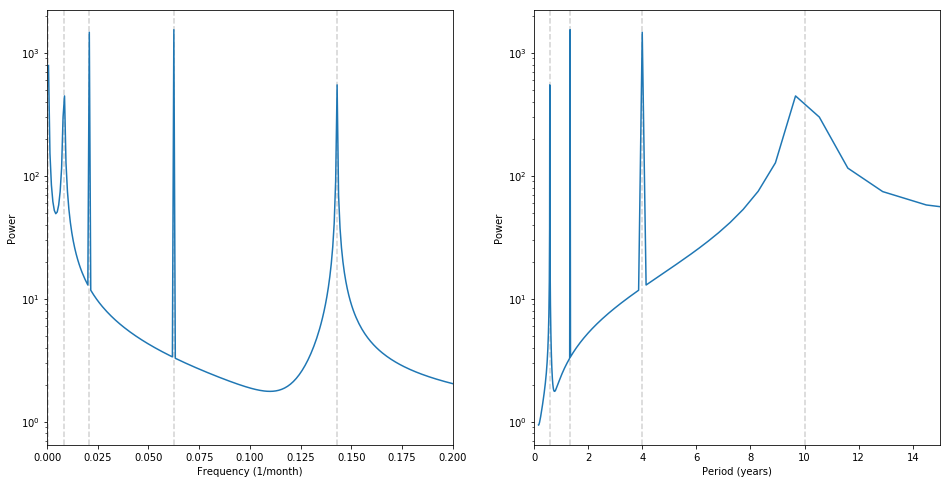

In [7]:
fig = plt.figure(figsize=(16,8)) 

ax1 = fig.add_subplot(1, 2, 1) 
for xc in gaussian_periods:
    ax1.axvline(x=1. / xc, ymax=1, color='lightgray', linestyle='--')
ax1.plot(frequencies[1:], unfiltered_power_spectrum[1:])
ax1.set_yscale('log')
ax1.set_xlabel('Frequency (1/month)')
ax1.set_ylabel('Power')
ax1.set_xlim([0,1/5])

ax2 = fig.add_subplot(1, 2, 2) 
for xc in gaussian_periods:
    ax2.axvline(x=xc/12, ymax=1, color='lightgray', linestyle='--')
ax2.plot(periods, unfiltered_power_spectrum[1:])
ax2.set_yscale('log')
ax2.set_xlim([0,15])
ax2.set_xlabel('Period (years)')
ax2.set_ylabel('Power')

plt.show()

<br>
<h2 style='text-align:center'>Implementing PCA</h2>
<br>
Now that we've created the data - let's apply PCA and visualize the results

In [124]:
num_components = 5

# Using the numpy eig function diagonalizes the entire covariance matrix, which is slow. The 
# PCA function seems to stop diagonalizing after the requested number of eigenvectors are determined - mucho mas rapido.
bespoke_but_slow = False  
if bespoke_but_slow:
    covariance_matrix = unfiltered_tx_data.T.dot(unfiltered_tx_data) / (tdim.cnt - 1)
    unfiltered_x_variances, eigenvectors = np.linalg.eig(covariance_matrix)
    unfiltered_x_EOFs = abs(eigenvectors[:num_components]) # eig returns imaginary vectors, so take the magnitude
else:
    pca = PCA(num_components) 
    pca.fit_transform(unfiltered_tx_data)
    unfiltered_x_EOFs = pca.components_
    unfiltered_x_variances = pca.explained_variance_

print(unfiltered_x_EOFs.shape)   
print(unfiltered_x_variances.shape)

(5, 2500)
(5,)


And let's visualize the spatial patterns. These are the eigenvalues of the covariance matrix - or in more intuitive language - the scaling axes of the transformation that accounts for the data variation.

It seems that the paper uses the term principle component differently than the PCA literature. A principle component in the sense of the PCA algorithm refers to the eigenvectors of the covariance matrix - what the paper calls an EOF.

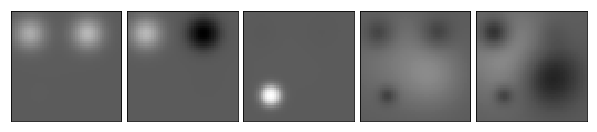

In [11]:
# Plot the EOFs
intensity_min = np.min(unfiltered_x_EOFs)
intensity_max = np.max(unfiltered_x_EOFs)

fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

for i in range(np.min([10, num_components])): 
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(unfiltered_x_EOFs[i,:], (udim.cnt, vdim.cnt)), cmap='Greys', vmin=intensity_min, vmax=intensity_max)

So, this is our grammar of patterns, or EOFs, ordered by their contribution to the variance in the dataset.

If we project the data onto these vectors, we can retrieve the principle components - the time series that describes how much of each EOF occures at each time.

In [12]:
unfiltered_PCs = (unfiltered_tx_data.dot(unfiltered_x_EOFs.T) / np.sqrt(unfiltered_x_variances)).T
print(unfiltered_PCs.shape)

(5, 1392)


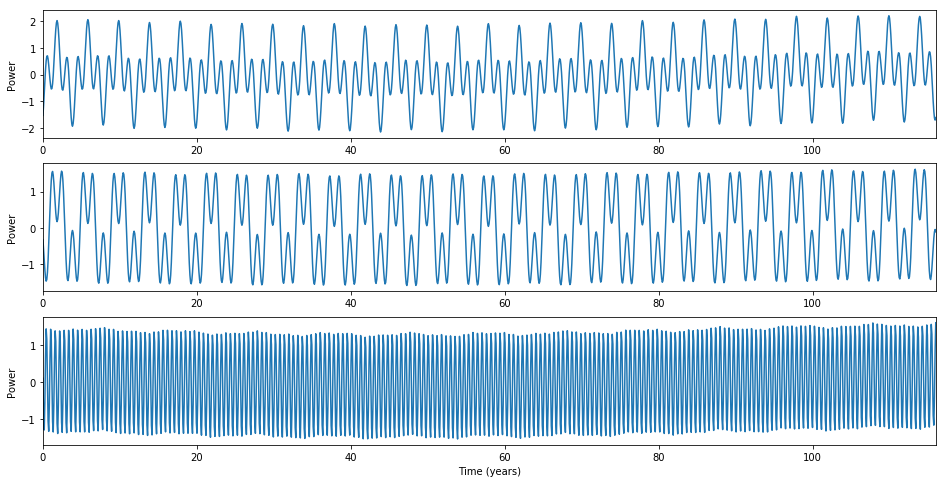

In [13]:
fig = plt.figure(figsize=(16,8)) 
maxval = max(unfiltered_PCs[0])

xaxis = np.linspace(tdim.lwr / 12, tdim.upr / 12, tdim.cnt)
for ic in range(3):
    ax = fig.add_subplot(3, 1, ic+1)
    ax.plot(xaxis, unfiltered_PCs[ic])
    ax.set_ylabel('Power')
    ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel('Time (years)')
plt.show()

We can clearly recognize evidence of interference between multiple frequencies. This means that the EOFs contain mixtures of the original guassians. 

Then the question is - is there a way to use the frequency information to distinguish the original gaussians?

<br>
<h2 style='text-align:center'>Implementing LFCA</h2>
<br>
In their paper, <a href='https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2017GL076327'>Wills, R. C. et al., 2018</a> "Disentangling global warming, multidecadal variability, and El Niño in Pacific temperatures", the authors propose a method called LFCA, where this PCA basis is rotated to a new basis which aligns the first axis such that it maximizes variance contained in the low frequency data vs the total data. They call this a basis of LFCs (low frequency components). By projecting the data onto the LFCs, they can identify the temporally correlated phenomena - suggesting a single cause. 

### Filtering The Data
To reproduce this, let's first define a filter. They use a Lanczos filter.

In [14]:
class signal_class:
    def __init__(self, ind, dep):
        self.ind = ind; self.dep = dep
    def head(self, cnt=5):
        print ("".join(map(lambda c1, c2: '(%.2f,\t%.2f)\n'% (c1, c2), (self.ind[:cnt]), self.dep[:cnt])))
    
class filter_class:           
    def __init__(self, fc, window_type='Lanczos', N=25):  
        assert N % 2 == 1
        n = np.arange(N)     
        sinc_filter = np.sinc(2 * fc * (n - (N - 1) / 2)) # Compute sinc filter.
        
        # Compute the selected type of window function
        if window_type=='Blackman':
            window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
        else:
            window = np.sinc(2 * n / (N - 1) - 1)
            
        h = sinc_filter * window # Apply the window function
        self.h = h / np.sum(h)
        self.N = N
    
    
    def apply_filter(self, x):
        s = np.r_[x[self.N-1:0:-1], x, x[-1:-self.N:-1]]
        y = np.convolve(self.h, s, mode='valid')
        return y[int(self.N/2):len(y)-int(self.N/2)]
    
    
    def filter_signal(self, signal):
        filtered_dep = self.apply_filter(signal.dep)
        return signal_class(signal.ind, filtered_dep)

Let's take a look at the Lanczos filter response. Our sampling rate is 1 Sample/Month. 

In [17]:
fc = 0.2  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
L = 1024  # Length of frequency response.
N = 25

blackman = np.concatenate((filter_class(fc, 'Blackman', N).h, np.zeros(L-N)))
lanczos = np.concatenate((filter_class(fc, 'Lanczos', N).h, np.zeros(L-N)))
 
blackman_response = np.abs(np.fft.fft(blackman))[0 : L // 2 + 1]
lanczos_response = np.abs(np.fft.fft(lanczos))[0 : L // 2 + 1]

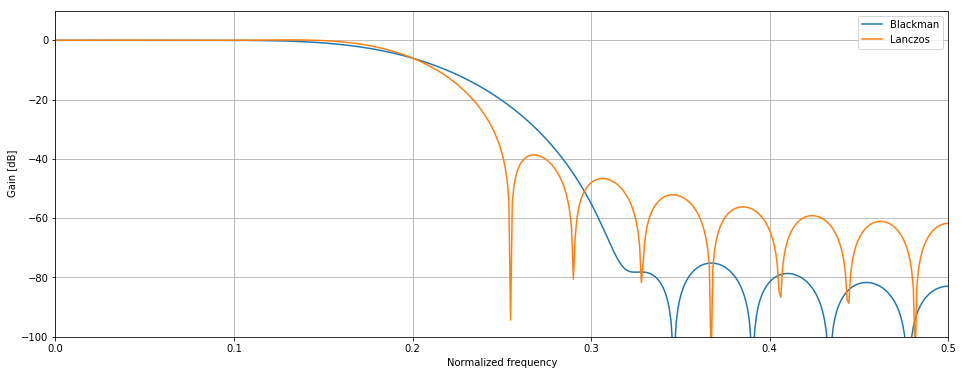

In [18]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.linspace(0, 0.5, L // 2 + 1), 20 * np.log10(blackman_response), label='Blackman')
ax.plot(np.linspace(0, 0.5, L // 2 + 1), 20 * np.log10(lanczos_response), label='Lanczos')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xlabel('Normalized frequency')
ax.set_ylabel('Gain [dB]')
ax.set_ylim([-100, 10])
ax.autoscale(enable=True, axis='x', tight=True)
ax.grid()
plt.show()

And now lets see how filtering changes the power spectrum of our data. (Again, interactive in the notebook)

In [19]:
unfiltered_flat_signal = signal_class(np.linspace(tdim.lwr, tdim.upr, tdim.cnt), np.sum(unfiltered_tx_data, axis=1))
unfiltered_flat_spectrum = signal_class(np.fft.fftfreq(tdim.cnt, d=tdim.stp)[:tdim.cnt//2], 
                        2.0 / tdim.cnt * abs(np.fft.fft(unfiltered_flat_signal.dep))[:tdim.cnt//2])

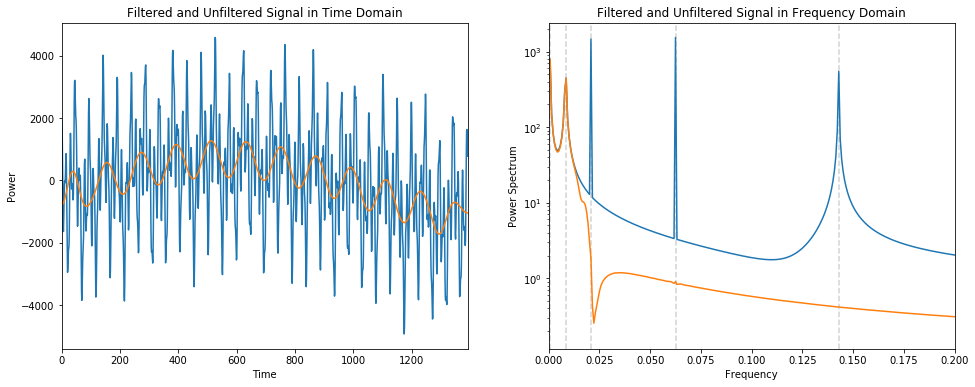

In [22]:
def system_plot(period): 
    lp_filter = filter_class(1/period, N=511)
    
    # Get the time filtered space average power in time and frequency space
    filtered_flat_signal = lp_filter.filter_signal(unfiltered_flat_signal)
#     b, a = signal.butter(5, 2 / period, 'low')
#     filtered_flat_signal = signal_class(unfiltered_flat_signal.ind, signal.filtfilt(b, a, unfiltered_flat_signal.dep))
    filtered_flat_spectrum = signal_class(np.fft.fftfreq(tdim.cnt, d=tdim.stp)[:tdim.cnt//2], 
                            2.0 / tdim.cnt * abs(np.fft.fft(filtered_flat_signal.dep))[:tdim.cnt//2])
    
    fig = plt.figure(figsize=(16,6)) 
    
    # Plot the Time Domain signal
    ax1 = fig.add_subplot(1, 2, 1) 
    ax1.plot(unfiltered_flat_signal.ind, unfiltered_flat_signal.dep)
    ax1.plot(filtered_flat_signal.ind, filtered_flat_signal.dep)
    ax1.set_title('Filtered and Unfiltered Signal in Time Domain')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Power')
    ax1.autoscale(enable=True, axis='x', tight=True)
    
    # Plot the frequency domain signal
    ax2 = fig.add_subplot(1, 2, 2) 
    for xc in gaussian_periods:
        ax2.axvline(x=1./xc, ymax=1, color='lightgray', linestyle='--')
    ax2.plot(unfiltered_flat_spectrum.ind[1:], unfiltered_flat_spectrum.dep[1:])
    ax2.plot(filtered_flat_spectrum.ind[1:], filtered_flat_spectrum.dep[1:])
    ax2.set_xlim([0,1/5])
    ax2.set_yscale('log')
    ax2.set_title('Filtered and Unfiltered Signal in Frequency Domain')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Power Spectrum')
    plt.show()


# interactive_plot = widgets.interactive(system_plot, period = widgets.IntSlider(min=1, max=200, step=1, value=1))
# interactive_plot
system_plot(60)

By decreasing the cutoff frequency, we should be eliminating more and more of the high frequency variance relative to the low frequency variance. Let's plot the total variance distributed between the filtered principle components as a function of frequency.

In [41]:
# Let's try to show the relative front-loading of variance as a function of filter frequency
step_size = 0.0025
num_samples = 60
frequencies = np.linspace(0, num_samples*step_size, num_samples)
component_scores = np.zeros([num_samples, num_components])

filtered_tx_data = unfiltered_tx_data.copy()
pca = PCA()
w = widgets.IntProgress(max=num_samples-1, description='executing:'); display(w)

for i in range(num_samples):
    lp_filter = filter_class(frequencies[i], N=511)
    
    for xi in range(udim.cnt * vdim.cnt): 
        filtered_tx_data[:,xi] = lp_filter.apply_filter(unfiltered_tx_data.T[xi])
    filtered_PCs = filtered_tx_data.dot(unfiltered_x_EOFs.T) / np.sqrt(unfiltered_x_variances)
    
    pca.fit_transform(filtered_PCs)
    component_scores[i] = pca.explained_variance_
    w.value+=1

IntProgress(value=0, description='executing:', max=59)

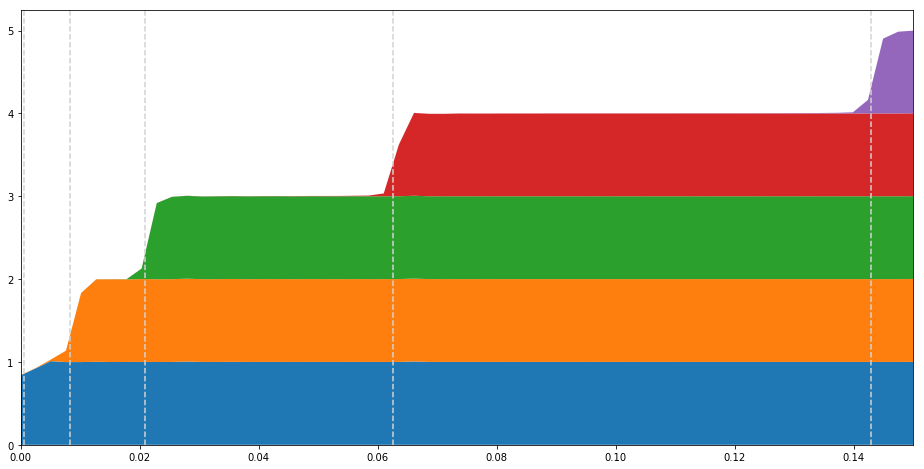

In [42]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
ax.stackplot(frequencies, component_scores.T)
for xc in gaussian_periods:
    ax.axvline(x=1./xc, ymax=1, color='lightgray', linestyle='--')
ax.set_xlim([0,0.15])
plt.show()

This is saying that if we filter the data above around 200 months, we can find a single linear combination of original EOFs that fully explains the variance in the filtered data. Once we decrease the cutoff period to around 100 months, we need two linear combinations to explain the data, etc.

### Constructing LFCs

Now we can filter the data and project it onto the LFC basis.

In [115]:
# Filter the data
lp_filter = filter_class(fc=1/200, N=511)
for i in range(udim.cnt * vdim.cnt): 
    filtered_tx_data[:,i] = lp_filter.apply_filter(unfiltered_tx_data.T[i])

filtered_PCs = filtered_tx_data.dot(unfiltered_x_EOFs.T) / np.sqrt(unfiltered_x_variances)

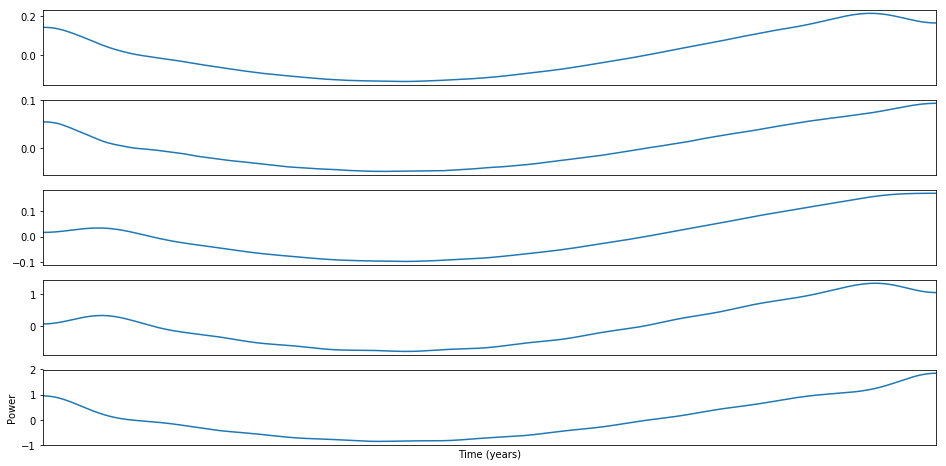

In [116]:
fig = plt.figure(figsize=(16,8)) 

xaxis = np.linspace(tdim.lwr / 12, tdim.upr / 12, tdim.cnt)
for ic in range(num_components):
    ax = fig.add_subplot(num_components, 1, ic+1, xticks=[])
    ax.plot(xaxis, filtered_PCs[:,ic])
    ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('Power')
ax.set_xlabel('Time (years)')
plt.show()

These filtered PCs indicate how much of each EOF is contributing to the filtered data at each time. We should see interference between the number of modes indicated by the previous chart - mixing more or less depending on how much of each mode exists in a particular filtered PC.

Now we can back out the LFPs as the linear combination of EOFs according to the variance-front-loaded basis of these filtered PCs.

In [123]:
pca.fit_transform(filtered_PCs)
# Normalize the eigenvalues
linear_combination_coefficients = pca.components_ / np.sum(pca.components_, axis=1, keepdims=True)
print(np.round(100*pca.explained_variance_))

linear_combination_vectors = unfiltered_x_EOFs.T.dot(linear_combination_coefficients.T) / np.sqrt(unfiltered_x_variances)
print(linear_combination_vectors.shape)

[101.   2.   0.   0.   0.]
(2500, 5)


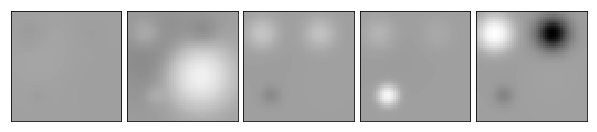

In [118]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

for i in range(np.min([10, num_components])): 
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(linear_combination_vectors.T[i,:], (50,50)), cmap='Greys', 
              vmin=np.min(linear_combination_vectors), vmax=np.max(linear_combination_vectors))

These linear combination vectors are mixes of EOFs which are variance-front-loaded in the filtered PCs - meaning, they are spatial patterns which front-load the time-variance in the space of filtered PCs.

The set of good questions includes:
- What is the difference between filtered PCs and LFCs?
- What is the difference between these linear combinations and LFPs?

The filtered PCs reproduce the *filtered* data along with these linear combination EOFs. But now we can use these linear combination EOFs to back out LFCs from the *unfiltered* data.


In [119]:
LFCs = unfiltered_tx_data.dot(linear_combination_vectors)
print(LFCs.shape)

(1392, 5)


Let's see what they look like:

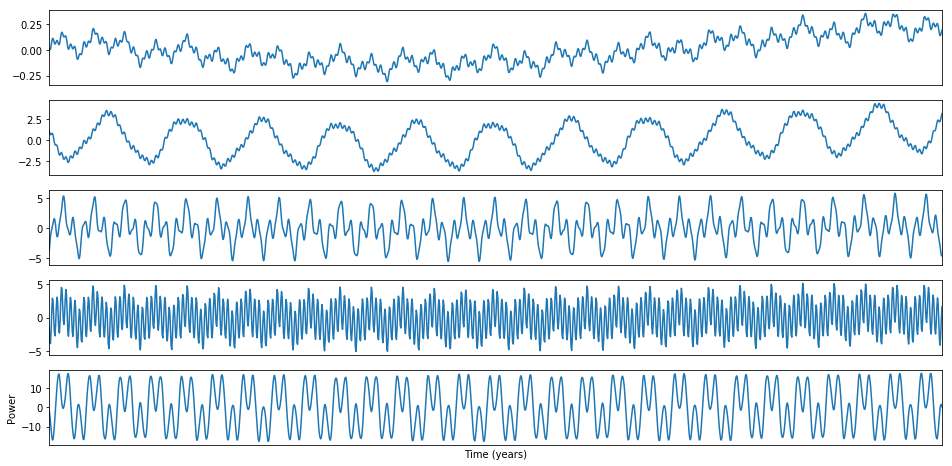

In [120]:
fig = plt.figure(figsize=(16,8)) 

xaxis = np.linspace(tdim.lwr / 12, tdim.upr / 12, tdim.cnt)
for ic in range(num_components):
    ax = fig.add_subplot(num_components, 1, ic+1, xticks=[])
    ax.plot(xaxis, LFCs[:,ic])
    ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('Power')
ax.set_xlabel('Time (years)')
plt.show()

And to get the LFPs, we need to reintroduce the variance that we removed.

In [121]:
LFPs2 = unfiltered_tx_data.T.dot(filtered_PCs).T
LFPs = LFPs2.T.dot(linear_combination_coefficients.T).T
# LFPs = unfiltered_tx_data.T.dot(LFCs).T
# LFPs = unfiltered_x_variances * unfiltered_x_EOFs.T.dot(linear_combination_coefficients)
# LFPs = LFPs.T
print(LFPs2.shape)
print(LFPs.shape)

(5, 2500)
(5, 2500)


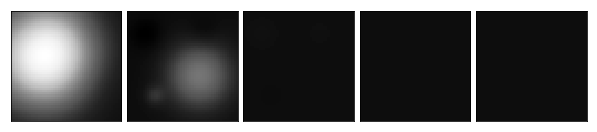

In [122]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

for i in range(np.min([10, num_components])): 
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(LFPs[i,:], (50,50)), cmap='Greys', vmin=np.min(LFPs), vmax=np.max(LFPs))

<br>
<h2 style='text-align:center'>Conclusion</h2>
<br>
In a subsequent post I hope to reproduce the results of the original paper. In the meantime, we've demonstrated that it's possible to use the frequency information to distinguish spatially overlapping patterns.

Some ideas and thoughts for future investigation:
1. Representing spatial extent of patterns as sums of gaussian distributions for futher dimension reduction
2. Is it possible to modify this method to handle patterns that slowly morph over time?
3. In the paper, they "subtracted teh climatological seasonal cycle" - it would be interesting to examine whether that mode of oscillation should be treated differently than the others under investigation.
4. By adding periodic boundary conditions, are we introducing bias into the results?

To do:
1. Clean up the math surrouding the construction of LFPs 
2. Add periodic boundary conditions to the data prior to filtering.
3. Plot effect of EOF truncation
4. Create visualizations of the LFCs and LFPs as a function of frequency